In [ ]:
pip install plantcv


In [ ]:
# Import software needed 
from plantcv import plantcv as pcv 
import numpy as np
import matplotlib.pyplot as pl

In [ ]:
class options:
    def __init__(self):
        self.image = "plante.jpeg"
        self.debug = "plot"
        self.writeimg= False 
        self.result = "./g2p_results"
        self.outdir = "."
# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

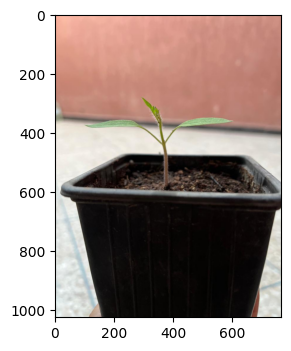

In [ ]:
# Inputs:
#   filename - Image file to be read in 
#   mode - Return mode of image; either 'native' (default), 'rgb', 'gray', or 'csv' 
img, path, filename = pcv.readimage(filename=args.image, mode='rgb')


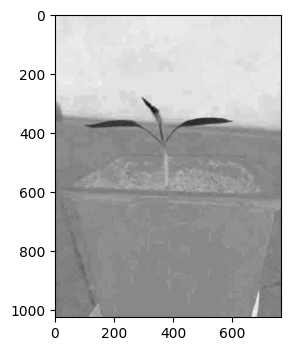

In [ ]:
# Convert RGB to LAB and extract the green-magenta channel ('a')

# Input:
#   rgb_img - RGB image data 
#   channel- Split by 'l' (lightness), 'a' (green-magenta), or 'b' (blue-yellow) channel
a_img = pcv.rgb2gray_lab(rgb_img=img, channel='a')


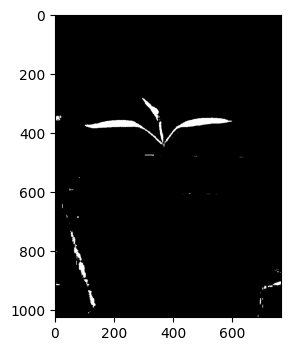

In [ ]:
# Threshold can be on either light or dark objects in the image. 

# Inputs:
#   gray_img - Grayscale image data 
#   threshold- Threshold value (between 0-255)
#   max_value - Value to apply above threshold (255 = white) 
#   object_type - 'light' (default) or 'dark'. If the object is lighter than the background then standard threshold is done.
#                 If the object is darker than the background then inverse thresholding is done. 
a_thresh_img = pcv.threshold.binary(gray_img=a_img, threshold=123, max_value=255, object_type='dark')


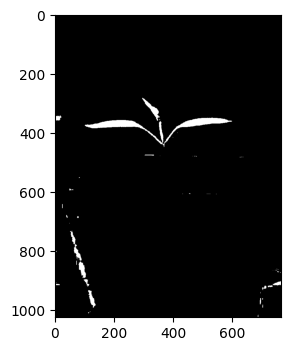

In [ ]:
# Filter out dark noise from an image.

# Inputs:
#   gray_img - Grayscale or binary image data
#   kernel - Optional neighborhood, expressed as an array of 1's and 0's. If None (default),
#   uses cross-shaped structuring element.
closed = pcv.closing(gray_img=a_thresh_img)

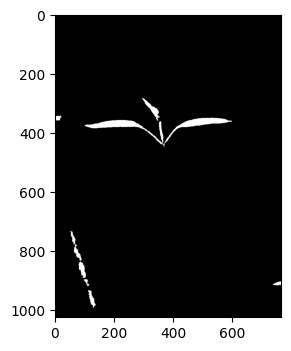

In [ ]:
# Fill small objects (reduce image noise) 

# Inputs: 
#   bin_img - Binary image data 
#   size - Minimum object area size in pixels (must be an integer), and smaller objects will be filled
filled = pcv.fill(bin_img=closed, size=130)


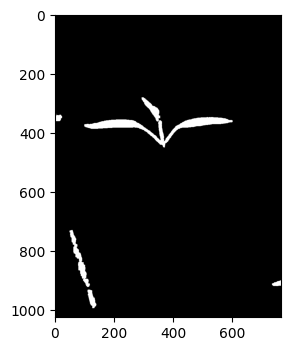

In [ ]:
# Dilate the mask to avoid losing leaf tips

# Inputs:
#    gray_img = input image
#    ksize    = kernel size, integer
#    i        = iterations, i.e. number of consecutive filtering passes
dilated = pcv.dilate(gray_img=filled, ksize=5, i=1)


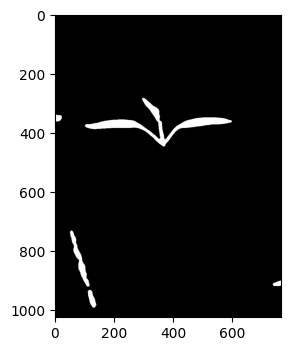

In [ ]:
# Use a lowpass (blurring) filter to smooth sobel image

# Inputs:
#   gray_img - Grayscale image data 
#   ksize - Kernel size (integer or tuple), (ksize, ksize) box if integer input,
#           (n, m) box if tuple input 
m_blur = pcv.median_blur(gray_img=dilated, ksize=12)

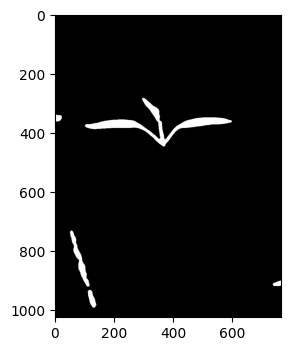

In [ ]:
# Fill in any holes in the plant mask

# Inputs:
#   bin_img - Binary image data
filled_mask = pcv.fill_holes(bin_img=m_blur)

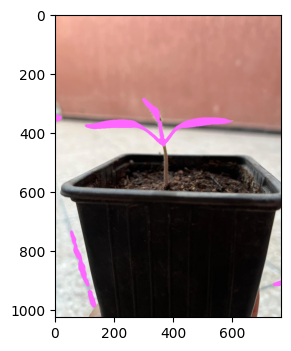

In [ ]:
# Identify objects

# Inputs: 
#   img - RGB or grayscale image data for plotting 
#   mask - Binary mask used for detecting contours 
obj_cnt, obj_hierarchy = pcv.find_objects(img=img, mask=filled_mask)

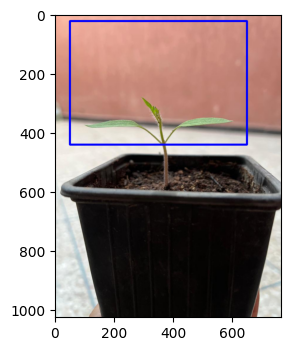

In [ ]:
# Define region of interest (ROI)

# Inputs: 
#   img - RGB or grayscale image to plot the ROI on 
#   x - The x-coordinate of the upper left corner of the rectangle 
#   y - The y-coordinate of the upper left corner of the rectangle 
#   h - The height of the rectangle 
#   w - The width of the rectangle 
roi_cnt, roi_hierarchy = pcv.roi.rectangle(img=img, x=50, y=20, h=420, w=600)

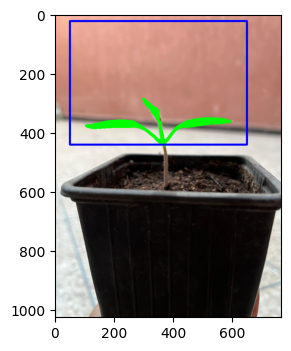

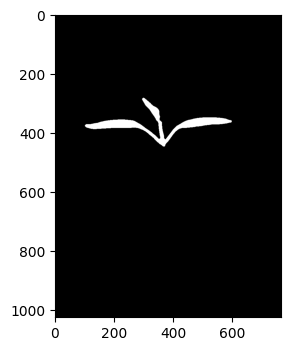

In [ ]:
# Decide which objects to keep

# Inputs:
#    img            = img to display kept objects
#    roi_contour    = contour of roi, output from any ROI function
#    roi_hierarchy  = contour of roi, output from any ROI function
#    object_contour = contours of objects, output from pcv.find_objects function
#    obj_hierarchy  = hierarchy of objects, output from pcv.find_objects function
#    roi_type       = 'partial' (default, for partially inside), 'cutto', or 
#    'largest' (keep only largest contour)
plant_obj, plant_hier, plant_mask, obj_area = pcv.roi_objects(img=img, roi_contour=roi_cnt, 
                                                               roi_hierarchy=roi_hierarchy, 
                                                               object_contour=obj_cnt, 
                                                               obj_hierarchy=obj_hierarchy,
                                                               roi_type='partial')

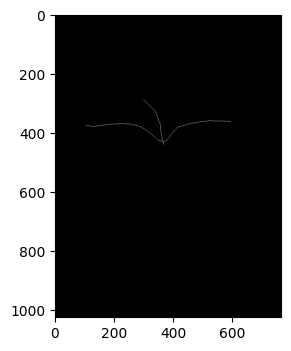

In [ ]:
# Skeletonize the plant mask (one-pixel wide representation)

# Inputs:
#   mask - Binary mask 
skeleton = pcv.morphology.skeletonize(mask=plant_mask)

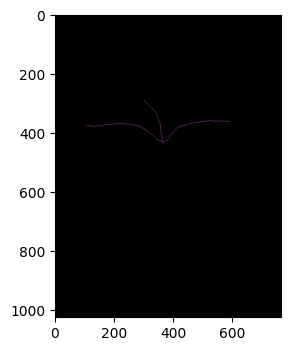

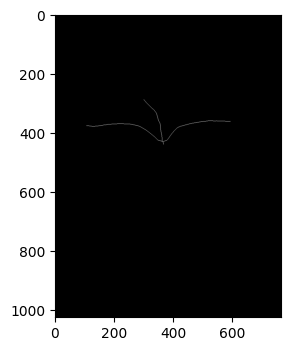

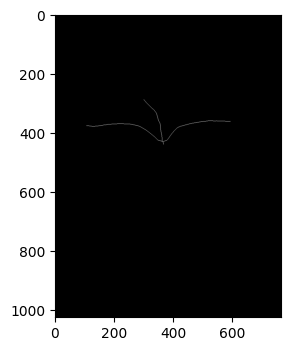

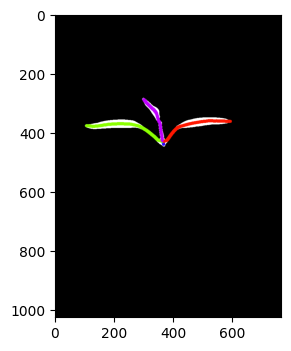

In [ ]:
# Adjust line thickness with the global line thickness parameter (default = 5),
# and provide binary mask of the plant for debugging. NOTE: the objects and
# hierarchies returned will be exactly the same but the debugging image (segmented_img)
# will look different.
pcv.params.line_thickness = 10

# Prune the skeleton  

# Inputs:
#   skel_img = Skeletonized image
#   size     = Pieces of skeleton smaller than `size` should get removed. (Optional) Default `size=0`. 
#   mask     = Binary mask for debugging (optional). If provided, debug images will be overlaid on the mask.

pruned, seg_img, edge_objects = pcv.morphology.prune(skel_img=skeleton, size=200, mask=plant_mask)

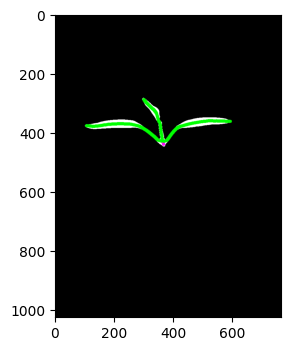

In [ ]:
# Inputs:
#   skel_img  = Skeletonized image
#   objects   = List of contours
#   mask      = (Optional) binary mask for debugging. If provided, debug image 
#                will be overlaid on the mask.

leaf_obj, stem_obj = pcv.morphology.segment_sort(skel_img=pruned, 
                                                 objects=edge_objects,
                                                 mask=plant_mask)


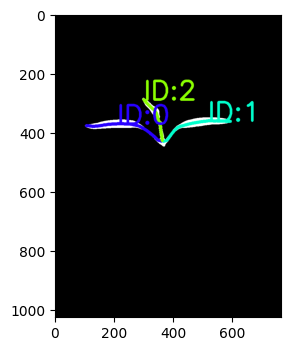

In [ ]:

pcv.params.text_size=3 # (default text_size=.55)
pcv.params.text_thickness=8 # (defaul text_thickness=2) 

# Identify segments     

# Inputs:
#   skel_img  = Skeletonized image
#   objects   = List of contours
#   mask      = (Optional) binary mask for debugging. If provided, debug image 
#                will be overlaid on the mask.

segmented_img, labeled_img = pcv.morphology.segment_id(skel_img=skeleton,
                                                       objects=leaf_obj,
                                                       mask=plant_mask)


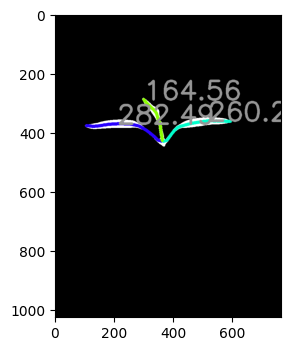

In [ ]:
# Measure path lengths of segments     

# Inputs:
#   segmented_img = Segmented image to plot lengths on
#   objects       = List of contours

labeled_img  = pcv.morphology.segment_path_length(segmented_img=segmented_img, 
                                                  objects=leaf_obj)


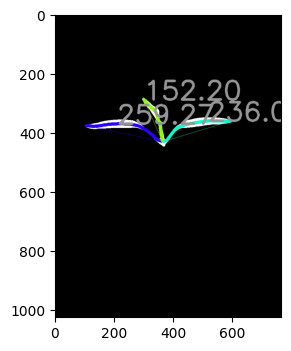

In [ ]:
# Measure euclidean distance of segments      

# Inputs:
#   segmented_img = Segmented image to plot lengths on
#   objects       = List of contours

labeled_img = pcv.morphology.segment_euclidean_length(segmented_img=segmented_img, 
                                                      objects=leaf_obj)


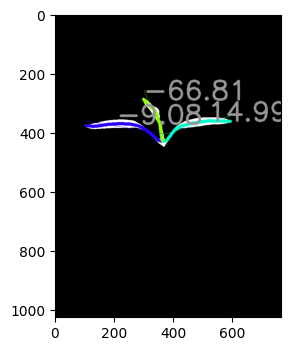

In [ ]:
# Measure the angle of segments      

# Inputs:
#   segmented_img = Segmented image to plot angles on
#   objects       = List of contours

labeled_img = pcv.morphology.segment_angle(segmented_img=segmented_img, 
                                           objects=leaf_obj)


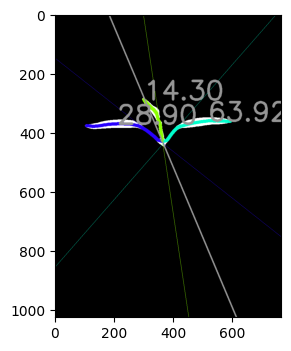

In [ ]:
# Measure the leaf insertion angles   
# Inputs:
#   skel_img         = Skeletonize image 
#   segmented_img    = Segmented image to plot insertion angles on
#   leaf_objects     = List of leaf contours
#   stem_objects     = List of stem objects 
#   size             = Size of the inner portion of each leaf to find a linear regression line

labeled_img = pcv.morphology.segment_insertion_angle(skel_img=skeleton,
                                                     segmented_img=segmented_img, 
                                                     leaf_objects=leaf_obj, 
                                                     stem_objects=stem_obj,
                                                     size=50)


#####################################################


In [ ]:
class options:
    def __init__(self):
        self.image = "planteG.jpeg"
        self.debug = "plot"
        self.writeimg= False 
        self.result = "./g2p_results"
        self.outdir = "."
# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

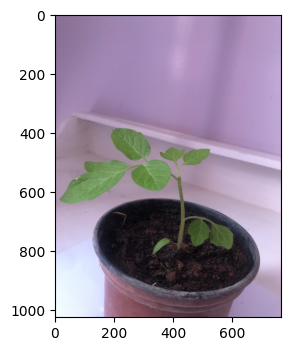

In [ ]:
# Inputs:
#   filename - Image file to be read in 
#   mode - Return mode of image; either 'native' (default), 'rgb', 'gray', or 'csv' 
img, path, filename = pcv.readimage(filename=args.image, mode='rgb')

In [ ]:
from plantcv import plantcv as pcv

# Set global debug behavior to None (default), "print" (to file), or "plot" (Jupyter Notebooks or X11)

pcv.params.debug = "print"

pcv.params.text_size=2 # (default text_size=.55)
 

# Read in the image

img, path, filename = pcv.readimage("/content/planteG.jpeg")

# Create masked image from a color image based LAB color-space and threshold values.
# for lower and upper_thresh list as: thresh = [L_thresh, A_thresh, B_thresh]

a_img = pcv.rgb2gray_lab(rgb_img=img, channel='a')

a_thresh_img = pcv.threshold.binary(gray_img=a_img, threshold=125, max_value=255, object_type='dark')

closed = pcv.closing(gray_img=a_thresh_img)

filled = pcv.fill(bin_img=closed, size=100)

dilated = pcv.dilate(gray_img=filled, ksize=5, i=1)

m_blur = pcv.median_blur(gray_img=dilated, ksize=12)

filled_mask = pcv.fill_holes(bin_img=m_blur)

obj_cnt, obj_hierarchy = pcv.find_objects(img=img, mask=filled_mask)


roi_cnt, roi_hierarchy = pcv.roi.rectangle(img=img, x=50, y=20, h=420, w=600)


plant_obj, plant_hier, plant_mask, obj_area = pcv.roi_objects(img=img, roi_contour=roi_cnt, 
                                                               roi_hierarchy=roi_hierarchy, 
                                                               object_contour=obj_cnt, 
                                                               obj_hierarchy=obj_hierarchy,
                                                               roi_type='partial')




#mask, masked_img = pcv.threshold.custom_range(img, lower_thresh=[30,65,20], upper_thresh=[70,255,220], channel='HSV')

# Crop the mask 
#cropped_mask = mask[350:1000, 100:1000]
#cropped_mask = mask[80:1000, 0:1000]

# Skeletonize the mask 
#skeleton = pcv.morphology.skeletonize(mask=plant_mask)

# Skeletonize the mask 

# Inputs:
#   mask = Binary image data

skeleton = pcv.morphology.skeletonize(mask=plant_mask)

# Prune the skeleton  

# Inputs:
#   skel_img = Skeletonized image
#   size     = Size to get pruned off each branch

img1 = pcv.morphology.prune(skel_img=skeleton, size=10)

# Identify branch points   

# Inputs:
#   skel_img = Skeletonized image
#   mask     = (Optional) binary mask for debugging. If provided, debug image will be overlaid on the mask.

branch_pts_mask = pcv.morphology.find_branch_pts(skel_img=skeleton, mask=plant_mask)

# Identify tip points   

# Inputs:
#   skel_img = Skeletonized image
#   mask     = (Optional) binary mask for debugging. If provided, debug image will be overlaid on the mask.

tip_pts_mask = pcv.morphology.find_tips(skel_img=skeleton, mask=None)

# Adjust line thickness with the global line thickness parameter (default = 5),
# and provide binary mask of the plant for debugging. NOTE: the objects and
# hierarchies returned will be exactly the same but the debugging image (segmented_img)
# will look different.
pcv.params.line_thickness = 3 

# Segment a skeleton into pieces   
seg_img, edge_objects = pcv.morphology.segment_skeleton(skel_img=skeleton, mask=plant_mask)

leaf_obj, stem_obj = pcv.morphology.segment_sort(skel_img=skeleton, 
                                                 objects=edge_objects,
                                                 mask=plant_mask)

# Identify segments     

# Inputs:
#   skel_img  = Skeletonized image
#   objects   = List of contours
#   mask      = (Optional) binary mask for debugging. If provided, debug image will be overlaid on the mask.

segmented_img, labeled_img = pcv.morphology.segment_id(skel_img=skeleton,
                                                       objects=leaf_obj,
                                                       mask=plant_mask)



# Measure path lengths of segments     

# Inputs:
#   segmented_img = Segmented image to plot lengths on
#   objects       = List of contours

labeled_img  = pcv.morphology.segment_path_length(segmented_img=segmented_img, 
                                                  objects=leaf_obj)

# Measure euclidean distance of segments      

# Inputs:
#   segmented_img = Segmented image to plot lengths on
#   objects       = List of contours

labeled_img3 = pcv.morphology.segment_euclidean_length(segmented_img=segmented_img, 
                                                      objects=leaf_obj)

# Measure the angle of segments      

# Inputs:
#   segmented_img = Segmented image to plot angles on
#   objects       = List of contours

labeled_img1 = pcv.morphology.segment_angle(segmented_img=segmented_img, 
                                           objects=leaf_obj)


# Measure the leaf insertion angles   
# Inputs:
#   skel_img         = Skeletonize image 
#   segmented_img    = Segmented image to plot insertion angles on
#   leaf_objects     = List of leaf contours
#   stem_objects     = List of stem objects 
#   size             = Size of the inner portion of each leaf to find a linear regression line

labeled_img2 = pcv.morphology.segment_insertion_angle(skel_img=skeleton,
                                                     segmented_img=segmented_img, 
                                                     leaf_objects=leaf_obj, 
                                                     stem_objects=stem_obj,
                                                     size=50)

Size too large, contour with ID# 0 got pruned away completely.
Size too large, contour with ID# 1 got pruned away completely.
Size too large, contour with ID# 4 got pruned away completely.
Size too large, contour with ID# 6 got pruned away completely.


Text(0.5, 1.0, 'la distance euclidienne des feuilles\n')

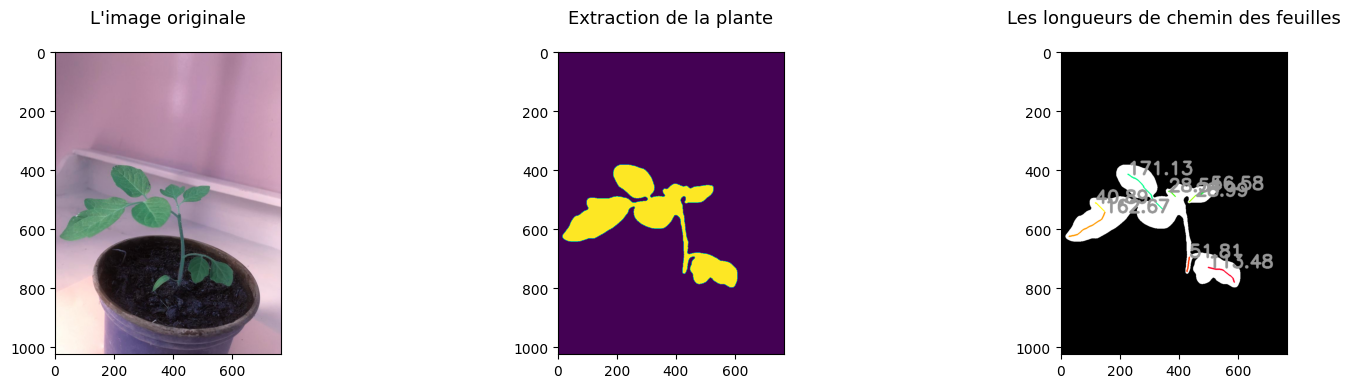

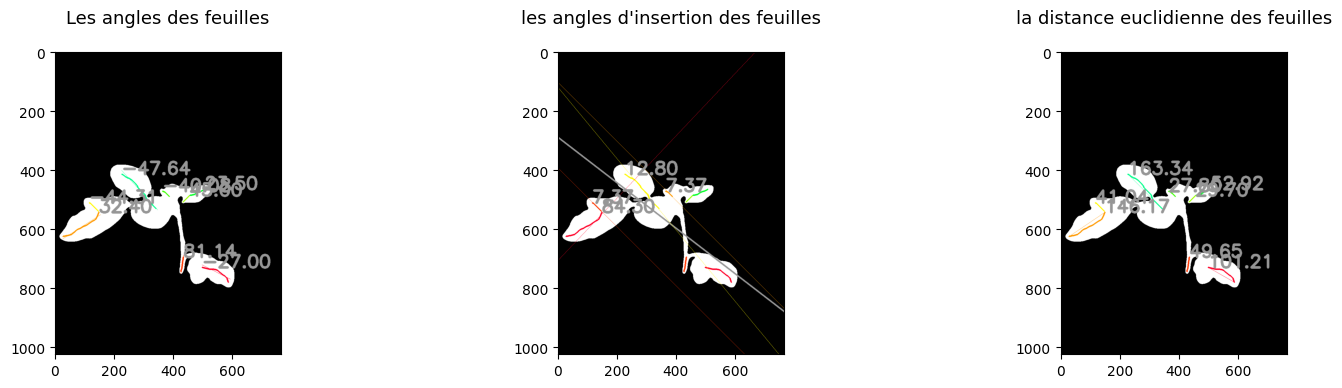

In [ ]:
import matplotlib.pyplot as pl
fig1, (ax1, ax2, ax3) = pl.subplots(1, 3)
pl.subplots_adjust(right=2.5)

ax1.imshow(img, cmap='gray')
ax1.set_title("L'image originale\n",fontsize=13)

ax2.imshow(plant_mask)
ax2.set_title("Extraction de la plante\n",fontsize=13)

ax3.imshow(labeled_img, cmap='gray')
ax3.set_title("Les longueurs de chemin des feuilles\n",fontsize=13)

fig2, (ax4, ax5, ax6) = pl.subplots(1, 3)
pl.subplots_adjust(right=2.5)

ax4.imshow(labeled_img1, cmap='gray')
ax4.set_title("Les angles des feuilles\n",fontsize=13)

ax5.imshow(labeled_img2, cmap='gray')
ax5.set_title("les angles d'insertion des feuilles\n",fontsize=13)

ax6.imshow(labeled_img3, cmap='gray')
ax6.set_title("la distance euclidienne des feuilles\n",fontsize=13)